In [500]:
#Initialize matplotlib notebook
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import cmath

#Create uv elements
uvxy = UVData()
uvyx = UVData()
uvxx = UVData()
uvyy = UVData()

#Create constant variables
#Variable for the speed of light
c = 3e8 #2.99792 * 1e8
#Variable for speed of light in a cable correction factor, based on Google search
f = .83

#Create an array of antennas we want to flag
flagged_antennas = np.array([0,2,26,50,84,98,136])

# Read in the xy data file
uvxy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_7.uvOCRSL.uvfits')#, antenna_nums=(antenna1,antenna2))

ant_nums = uvxy.antenna_numbers

#Create a dictionary which associates the antenna number with the indexing number in ants
ant_dict = {x: i for i,x in enumerate(ant_nums)}

#Create the baseline dependent tau matrix
taus_a = np.zeros((len(ant_nums),len(ant_nums)))
i = 0
j = 0
for ind,coord in enumerate(uvxy.uvw_array):
    if j==52:
        #This if statement iterates the indicies for the created tau array
        #When j hits 52, it has reached the end of the list of antennas
        #This means that we need to move to the next line and so i is iterated
        #But we cannot simply resent j to zero because the uvw array does not repeat baselines
        #We set j equal to i, as the new row will start will the autocorr baseline
        i = i + 1
        j = i
    taus_a[i,j] = np.sqrt(coord[0]**2 + coord[1]**2 + coord[2]**2) 
    taus_a[i,j] = taus_a[i,j] / c
    j = j + 1

In [558]:
#Define antenna numbers 
antenna1 = 121
antenna2 = 25


In [559]:
#Define the tau variable for the specified antenna pair
#Since the array created is upper triangular, we must index using an if statement
if antenna1<antenna2:
    tau_ai = taus_a[ant_dict[antenna1],ant_dict[antenna2]]
else:
    tau_ai = taus_a[ant_dict[antenna2],ant_dict[antenna1]]

print tau_ai*c, '(m)'
print tau_ai*1e9, '(ns)'

75.90589182985778 (m)
253.0196394328593 (ns)


In [560]:
#Define frequency variable
nu = uvxy.freq_array
print nu.shape
#Nu is in Hz, or 1/seconds

if antenna1>antenna2:
    e_a = np.e**(nu * np.pi * (1j) * 2 * (tau_ai + 1e-8))
else: 
    e_a = np.e**(nu * np.pi * (-1j) * 2 * (tau_ai + 1e-8))

print e_a.shape
print np.mean(e_a)

print np.argwhere(e_a==np.max(e_a))

(1, 1024)
(1, 1024)
(-0.00915619713478366+0.0036183315830006875j)
[[  0 144]]


In [561]:
# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delay_xy = np.fft.fftshift(np.fft.fft(e_a,axis=1))
vis_avg_delay_xy = np.mean(vis_avg_delay_xy,axis=0)
print vis_avg_delay_xy.shape
print np.max(vis_avg_delay_xy)

# 2) Find the frequency width of a channel in GHz
freq_width_xy = np.diff(nu[0,:])[0]
print freq_width_xy

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays_xy = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width_xy))*1e9
print delays_xy.shape

model_max = np.max(np.abs(vis_avg_delay_xy))
print model_max
blin_peak = np.argwhere(np.abs(vis_avg_delay_xy)==model_max)
blin_peak = int(blin_peak)
print blin_peak
print delays_xy[np.argwhere(np.abs(vis_avg_delay_xy)==model_max)]


(1024,)
(363.2310219320392-109.78192009130574j)
97656.25
(1024,)
877.1763682608548
538
[[260.]]


In [562]:
# 1) Fourier transform "vis_avg" along the freq axis
vis_t = np.mean(uvxy.get_data(antenna1,antenna2),axis=0)
print vis_t.shape

vis_avg_delay_t = np.fft.fftshift(np.fft.fft(vis_t))
print vis_avg_delay_t.shape

# 2) Find the frequency width of a channel in GHz
freq_width_t = np.diff(uvxy.freq_array[0,:])[0]
print freq_width_t

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays_t = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width_t)*1e9)
print np.mean(delays_t)
print delays_t

real_bl_max = np.max(np.abs(vis_avg_delay_t[(blin_peak-2):(blin_peak+2)]))
real_abs_max = np.max(np.abs(vis_avg_delay_t))
print real_bl_max
print real_abs_max
print np.argwhere(np.abs(vis_avg_delay_t)==real_abs_max)
print delays_t[np.argwhere(np.abs(vis_avg_delay_t)==real_abs_max)]

(1024,)
(1024,)
97656.25
-5.0
[-5120. -5110. -5100. ...  5090.  5100.  5110.]
7.5485773
27.645802
[[516]]
[[40.]]


Antenna 121 and 25


<IPython.core.display.Javascript object>


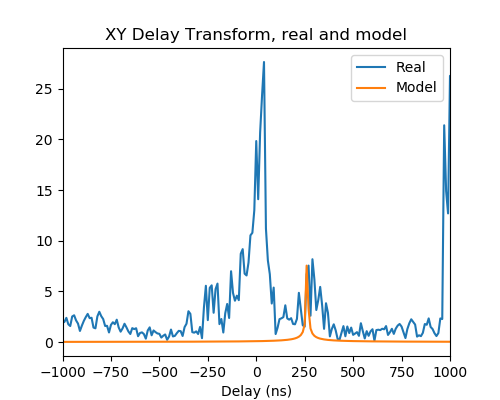

Text(0.5,1,'XY Delay Transform, real and model')

In [563]:
#Plot
amp_factor = model_max / real_bl_max
print 'Antenna', antenna1, 'and', antenna2

plt.figure(figsize=(5,4))

plt.plot((delays_t),np.abs(vis_avg_delay_t), label='Real')
plt.plot((delays_xy),np.abs(vis_avg_delay_xy)/amp_factor, label='Model')
plt.xlabel('Delay (ns)')
plt.xlim(-1000,1000) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

In [564]:
#build arrays
ind_amp = np.zeros([1,uvxy.Nfreqs])
ind_delays = np.zeros([2,len(ant_nums)])
blin_start = blin_peak - 10
print 'blin start:', blin_start
ind_delays = np.zeros([1,2])
print 'blin peak:', blin_peak
blin_end = blin_peak + 10
print 'blin end:', blin_end

for i,ant1 in enumerate(uvxy.ant_2_array):
    #Get the second antenna number using the index number
    ant2 = uvxy.ant_1_array[i]
    
    if (ant1==antenna1 and ant2==antenna2) or (ant1==antenna2 and ant2==antenna1):
        # Create an array to hold the night's data
        spectrum = uvxy.data_array[i,0,:,0]
        # Fourier transform along the time axis
        vis = np.fft.fftshift(np.fft.fft(spectrum))
        print vis.shape
        freq_width = np.diff(uvxy.freq_array[0,:])[0]
        #Convert frequencies to delays and convert to ns
        con_delays = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs, freq_width))*1e9
        #print np.abs(vis)[:blin_start]
        #print np.abs(vis)[blin_peak]
        #print (vis)[601]
        #print np.abs(vis)[496]
        #print con_delays[496]
        #'''
        peak_below_bl = np.max(np.abs(vis)[:blin_start])
        print 'Peak below:', peak_below_bl
        peak_above_bl = np.max(np.abs(vis)[blin_end:])
        print 'Peak above:', peak_above_bl
        #Find the corresponding delay
        delay_a = con_delays[np.argwhere((np.abs(vis))==peak_above_bl)]
        print 'Delay a location:',np.argwhere((np.abs(vis))==peak_above_bl)
        print 'Delay a:', delay_a
        delay_b = con_delays[np.argwhere((np.abs(vis))==peak_below_bl)]
        print 'Delay b:', delay_b
        print 'Delay b location:', np.argwhere((np.abs(vis))==peak_below_bl)
        #'''
        #Append the delay array with a list of the antenna pair and the delay
        ind_delays[0][1] = delay_a / 1e9
        ind_delays[0][0] = delay_b / 1e9
        

#Convert to numpy arrays
print 'Baseline independent delay array shape:', ind_delays.shape
print 'Baseline independent delay array in ns:', ind_delays*1e9

blin start: 528
blin peak: 538
blin end: 548
(1024,)
Peak below: 27.645802
Peak above: 3.0046732
Delay a location: [[623]]
Delay a: [[1110.]]
Delay b: [[-40.]]
Delay b location: [[508]]
Baseline independent delay array shape: (1, 2)
Baseline independent delay array in ns: [[ -40. 1110.]]


In [565]:
#model
if antenna1>antenna2:
    e_c_a = np.e**((1j) * 2 * np.pi * nu * (ind_delays[0,1]))# + 1e-8))
else:
    e_c_a = np.e**((-1j) * 2 * np.pi * nu * (ind_delays[0,1]))# + 1e-8))

print e_c_a.shape
print np.mean(e_c_a)

if antenna1>antenna2:
    e_c_b = np.e**((1j) * 2 * np.pi * nu * (ind_delays[0,0] + 1e-8))
else:
    e_c_b = np.e**((-1j) * 2 * np.pi * nu * (ind_delays[0,0] + 1e-8))

print e_c_b.shape
print np.mean(e_c_b)

(1, 1024)
(1.8610330290713684e-15-3.8120548384590336e-16j)
(1, 1024)
(7.632783294297951e-17-1.3877787807814457e-17j)


In [566]:
# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_a = np.fft.fftshift(np.fft.fft(e_c_a,axis=1))
vis_avg_a = np.mean(vis_avg_a,axis=0)
print vis_avg_a.shape
print np.max(vis_avg_a)

model_a = np.max(np.abs(vis_avg_a))
print model_a
print np.argwhere(np.abs(vis_avg_a)==model_a)
ind_peak1 = delays_xy[np.argwhere(np.abs(vis_avg_a)==model_a)]
print ind_peak1

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_b = np.fft.fftshift(np.fft.fft(e_c_b,axis=1))
vis_avg_b = np.mean(vis_avg_b,axis=0)
print vis_avg_b.shape
print np.max(vis_avg_b)

model_b = np.max(np.abs(vis_avg_b))
print model_b
print np.argwhere(np.abs(vis_avg_b)==model_b)
ind_peak2 = delays_xy[np.argwhere(np.abs(vis_avg_b)==model_b)]
print ind_peak2

(1024,)
(1023.9999999999999-7.72326470408079e-11j)
1023.9999999999999
[[623]]
[[1110.]]
(1024,)
(1024-2.677258292335029e-12j)
1024.0
[[509]]
[[-30.]]


<IPython.core.display.Javascript object>


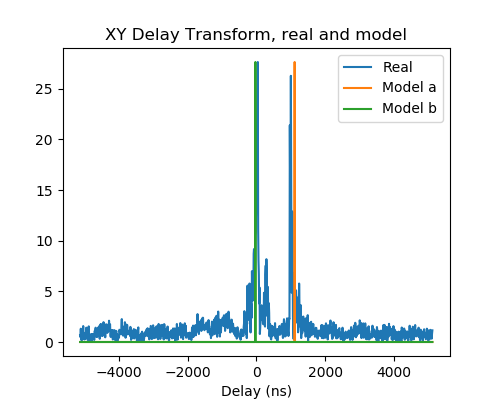

Text(0.5,1,'XY Delay Transform, real and model')

In [567]:
#plot
f = model_b / real_abs_max
fa = model_a / real_abs_max
plt.figure(figsize=(5,4))

plt.plot((delays_t),np.abs(vis_avg_delay_t), label='Real')
plt.plot((delays_xy),np.abs(vis_avg_a)/f, label='Model a')
plt.plot((delays_xy),np.abs(vis_avg_b)/fa, label='Model b')
plt.xlabel('Delay (ns)')
#plt.xlim(-1000,1500) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

<IPython.core.display.Javascript object>


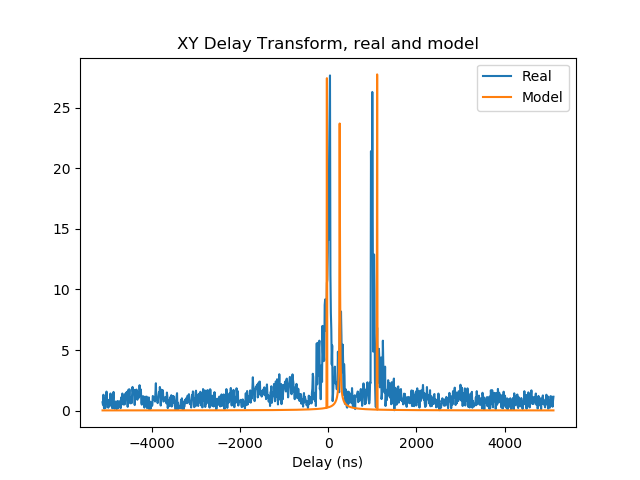

Text(0.5,1,'XY Delay Transform, real and model')

In [568]:
#combined model
model = e_a + e_c_a + e_c_b

vis = np.fft.fftshift(np.fft.fft(model,axis=1))
vis = np.mean(vis,axis=0)

plt.figure()

plt.plot((delays_t),np.abs(vis_avg_delay_t), label='Real')
plt.plot((delays_xy),np.abs(vis)/f, label='Model')
plt.xlabel('Delay (ns)')
#plt.xlim(-1000,1000) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

In [569]:
#Start creating the amplitude arrays
V_k = np.zeros((len(ant_nums),uvxy.Nfreqs),dtype='complex')
print V_k.shape

# Step through each antenna and find autocorr data
for i,ant1 in enumerate(uvxy.ant_2_array):
    ant2 = uvxy.ant_1_array[i]
    if (ant1==ant2):
        x = uvxy.data_array[i,0,:,0]
        V_k[ant_dict[ant1]] = x
        
#Get autocorr variables
V_ii = V_k[ant_dict[antenna1]]
V_jj = V_k[ant_dict[antenna2]]

#Define baseline dependent term
V_aij = e_a * (V_ii + V_jj) / 20.

print V_aij.shape
print np.mean(V_aij)

#First dimension is 2 to hold the amplitudes for above and below baseline
#Dimentions 2 and 3 hold the matrix of antenna pairs
ind_amp = np.zeros([1,2,len(ant_nums),len(ant_nums)])
bl_amp = np.zeros([1,len(ant_nums),len(ant_nums)])

for index,ant1 in enumerate(uvxy.ant_2_array):
    #Get the second antenna number using the index number
    ant2 = uvxy.ant_1_array[index]

    #Flag out dead antennas
    if np.any(ant1==flagged_antennas) or np.any(ant2==flagged_antennas):
        continue

    # Create an array to hold the night's data
    spectrum = uvxy.data_array[index,0,:,0]
    # Fourier transform along the time axis
    vis = np.fft.fftshift(np.fft.fft(spectrum))
    # Find the maximum amplitudes and put into a variable
    bl_peak = np.max(np.abs(vis)[blin_start:blin_end])
    peak_below_bl = np.max(np.abs(vis)[:blin_start])
    peak_above_bl = np.max(np.abs(vis)[blin_end:])
    # Append the maximum amplitude array with he peak
    bl_amp[0,ant_dict[ant1],ant_dict[ant2]] = bl_peak
    bl_amp[0,ant_dict[ant2],ant_dict[ant1]] = bl_peak
    ind_amp[0,0,ant_dict[ant1],ant_dict[ant2]] = peak_below_bl
    ind_amp[0,1,ant_dict[ant1],ant_dict[ant2]] = peak_above_bl
    ind_amp[0,0,ant_dict[ant2],ant_dict[ant1]] = peak_below_bl
    ind_amp[0,1,ant_dict[ant2],ant_dict[ant1]] = peak_above_bl

print bl_amp.shape
print ind_amp[:,1].shape

(52, 1024)
(1, 1024)
(0.010916041482833263-0.0013833456272224418j)
(1, 52, 52)
(1, 52, 52)


In [570]:
#variables
V_caij = e_c_a * (V_ii + V_jj) / 7.
V_cbij = e_c_b * (V_ii + V_jj) / 40.

#print V_cij.shape
print V_aij.shape


bl_mod = np.einsum('imn,ij->mnj',bl_amp,V_aij)
print bl_mod.shape

ind_a = np.einsum('imn,ij->mnj',ind_amp[:,1],V_caij)
ind_b = np.einsum('imn,ij->mnj',ind_amp[:,0],V_cbij)

print ind_a.shape
print ind_b.shape

model_com = bl_mod + ind_a + ind_b
ant_mod = model_com[ant_dict[antenna1],ant_dict[antenna2]]
ant_mod = ant_mod[None,:]
print ant_mod.shape

vis_mod = np.mean(np.fft.fftshift(np.fft.fft(ant_mod,axis=1)),axis=0)


(1, 1024)
(52, 52, 1024)
(52, 52, 1024)
(52, 52, 1024)
(1, 1024)


<IPython.core.display.Javascript object>


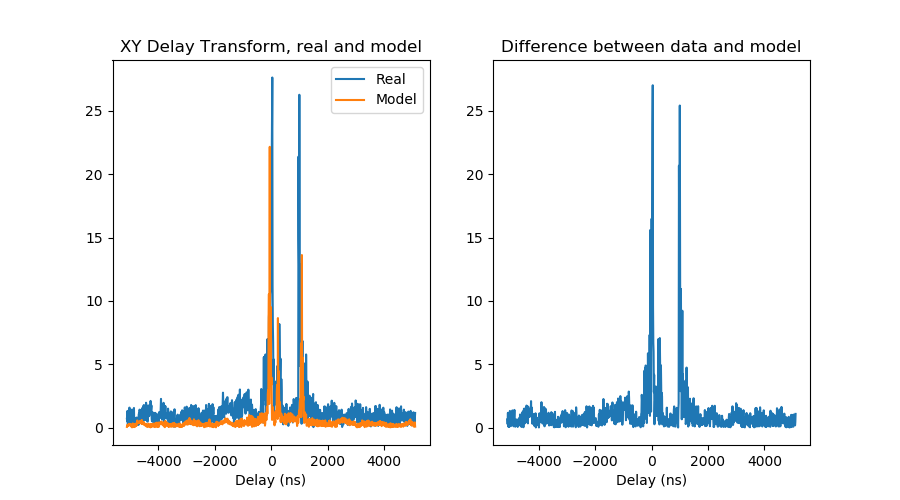

Text(0.5,1,'Difference between data and model')

In [572]:
corr_f = 150
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, sharey = ax1, sharex = ax1)

plt.subplot(ax1)
plt.plot((delays_t),np.abs(vis_avg_delay_t), label='Real')
plt.plot((delays_xy),np.abs(vis_mod)/corr_f, label='Model')
plt.xlabel('Delay (ns)')
#plt.xlim(-500,500) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

plt.subplot(ax2)
plt.plot(delays_t, np.abs(np.abs(vis_avg_delay_t)-np.abs(vis_mod)/corr_f))
plt.xlabel('Delay (ns)')
plt.title('Difference between data and model')